In [12]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from plotTools import config
config(dpi = 1.5 * 100)
import scipy.stats as stats
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, \
    OrdinalEncoder, PolynomialFeatures, StandardScaler

### Using statsmodels:

In [6]:
import statsmodels.api as sm

In [7]:
df = pd.read_csv("https://www.openml.org/data/get_csv/20649148/freMTPL2freq.arff",
                 quotechar="'")

# rename column names '"name"' => 'name' 
df.rename(lambda x: x.replace('"', ''), axis='columns', inplace=True)
df['IDpol'] = df['IDpol'].astype(np.int64)
df.set_index('IDpol', inplace=True)

In [14]:
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [15]:
df.describe(include = [np.object])

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


In [8]:
from plotting import savefig

/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Text(0.5, 1.0, 'Histogramme de la variable exposition')

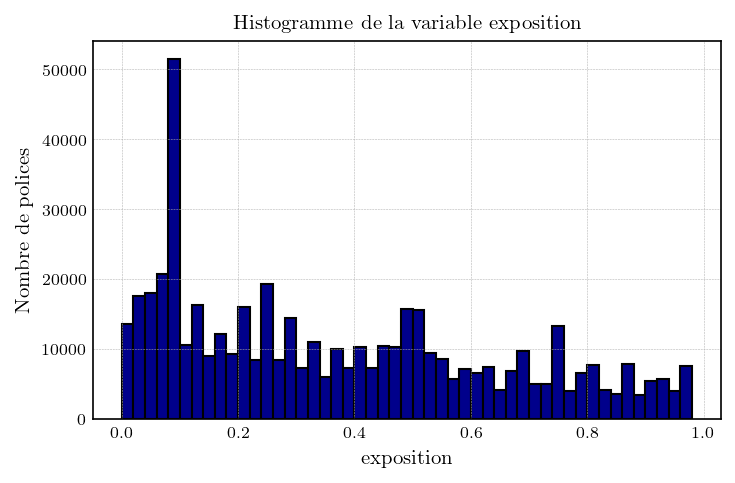

In [9]:
x = np.arange(0., 1., .02)
plt.hist(df['Exposure'], ec = 'k', bins = x)
plt.xlabel('exposition')
plt.ylabel('Nombre de polices')
plt.title('Histogramme de la variable exposition')
#savefig('./figures/exp')

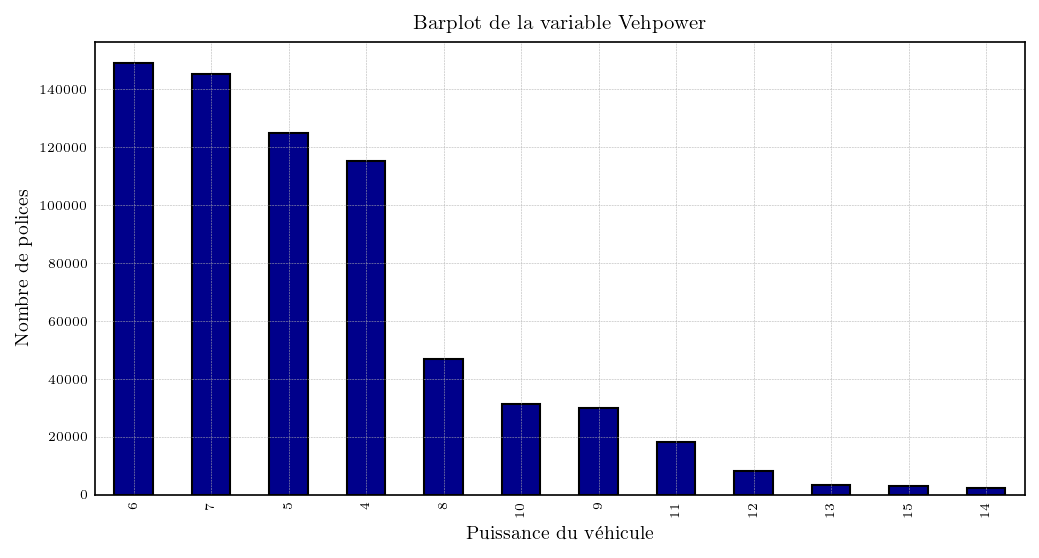

In [94]:
df['VehPower'].value_counts().plot(kind = 'bar', ec = 'k')
plt.xlabel('Puissance du véhicule')
plt.ylabel('Nombre de polices')
plt.title('Barplot de la variable Vehpower')
savefig('./figures/vehpower')

In [90]:
df = df.assign(freq = lambda x: x.ClaimNb * x.Exposure / x.Exposure.sum())

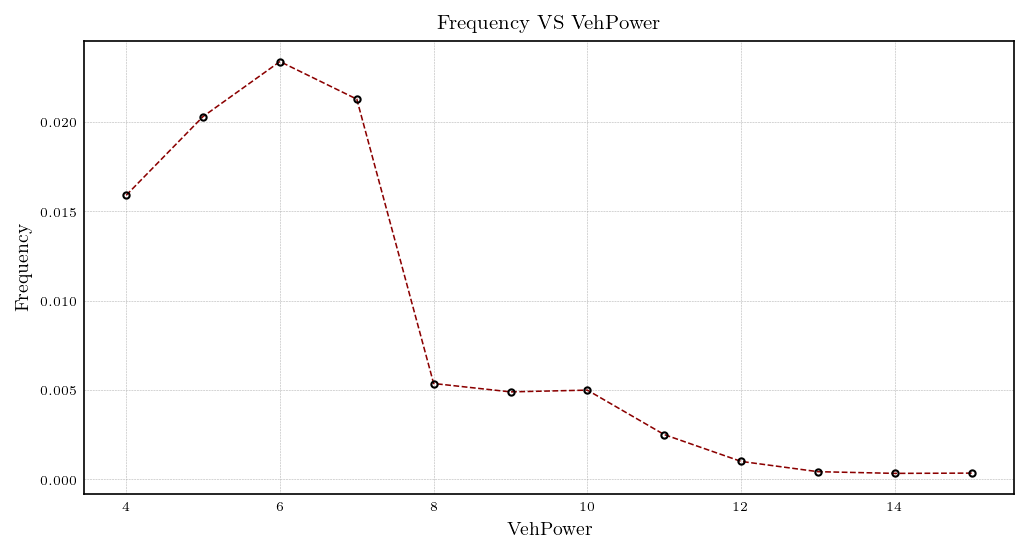

In [108]:
df.groupby('VehPower').agg('sum')['freq'].plot(marker = 'o', linestyle = 'dashed', color = 'darkred', markerfacecolor = 'darkblue', markeredgecolor = 'k')
plt.ylabel('Frequency')
plt.title('Frequency VS VehPower')
savefig('./figures/freqVSvp')

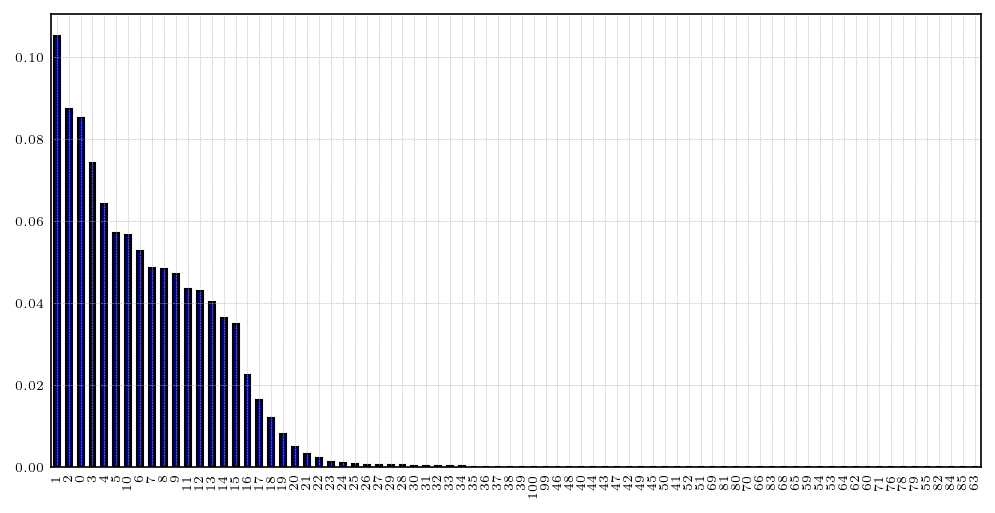

In [116]:
df['VehAge'].value_counts(normalize=True).plot(kind = 'bar', ec = 'k')
savefig('./figures/vehagedist')

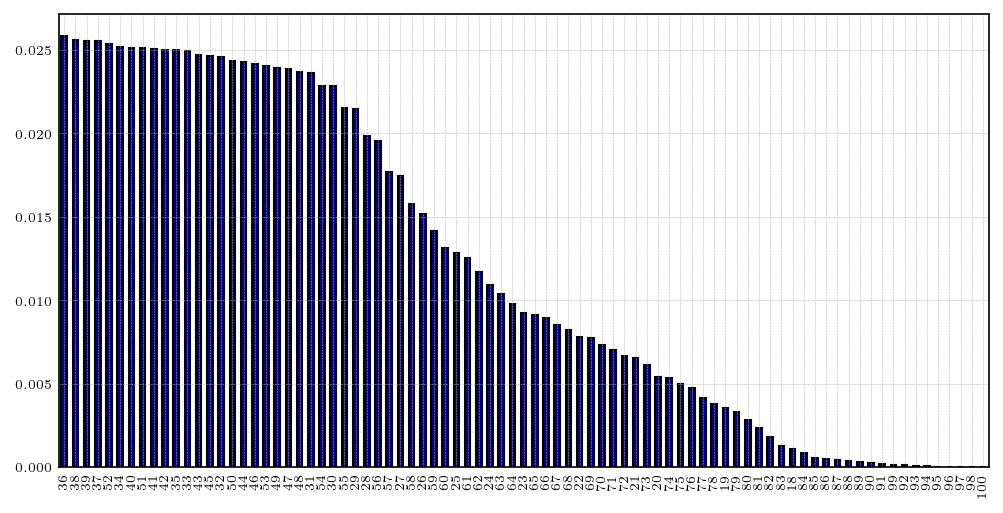

In [117]:
df['DrivAge'].value_counts(normalize=True).plot(kind = 'bar', ec = 'k')
savefig('./figures/drvagedist')

In [13]:
def gen_col_trans(drop=True, standardize=False):
    dd = {'VehPower': [4],
          'VehAge': [1],
          'DrivAge': [4],
          'VehBrand': ['B1'],
          'VehGas': ['Diesel'],
          'Region': ['R24']}
    if drop is False:
        for key, value in dd.items():
            dd[key] = None
    column_trans = ColumnTransformer(
    [
    # VehPower 4, 5, 6, 7, 8, 9, drop=4
    ('VehPower_cat',
      Pipeline([('cut_9', FunctionTransformer(lambda x: np.minimum(x, 9), validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['VehPower']))]),
      ['VehPower']),
     # VehAge intervals [0,1), [1, 10], (10, inf), drop=[1,10]
     ('VehAge_cat',
      Pipeline([('bin',
                 FunctionTransformer(lambda x: np.digitize(np.where(x==10, 9, x), bins=[1,10]),
                                     validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['VehAge']))
               ]),
      ['VehAge']),
     # DrivAge intervals [18,21), [21,26), [26,31), [31,41), [41,51), [51,71),[71,∞), drop=[41,51)
     ('DrivAge_cat',
      Pipeline([('bin',
                 FunctionTransformer(lambda x: np.digitize(x, bins=[21, 26, 31, 41, 51, 71]),
                                     validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['DrivAge']))
               ]),
      ['DrivAge']),
     ('BonusMalus',
          Pipeline([('cutat150',
                     FunctionTransformer(lambda x: np.minimum(x, 150), validate=False))
                   ] + ([('norm', StandardScaler())] if standardize else [])),
      ['BonusMalus']),
     ('VehBrand_cat', OneHotEncoder(drop=dd['VehBrand']), ['VehBrand']),
     ('VehGas_Regular', OneHotEncoder(drop=dd['VehGas']), ['VehGas']),
     ('Density_log',
          Pipeline([('log', FunctionTransformer(lambda x: np.log(x), validate=False))
                   ] + ([('norm', StandardScaler())] if standardize else [])),
      ['Density']),
     ('Region_cat', OneHotEncoder(drop=dd['Region']), ['Region']),     
     ('Area_ord', Pipeline([('OE', OrdinalEncoder()),
                            ('plus_1', FunctionTransformer(lambda x: x+1, validate=False))
                           ] + ([('norm', StandardScaler())] if standardize else [])),
      ['Area']), 
    ],
    remainder = 'drop')
    column_trans_names = ['VehPower_4', 'VehPower_5', 'VehPower_6',
                          'VehPower_7', 'VehPower_8', 'VehPower_9',
                          'VehAge_[0,1)', 'VehAge_[1, 10]', 'VehAge_(10,inf)',
                          'DrivAge_[18,21)', 'DrivAge_[21,26)', 'DrivAge_[26,31)',
                          'DrivAge_[31,41)', 'DrivAge_[41,51)', 'DrivAge_[51,71)', 'DrivAge_[71,inf)',
                          'BonusMalus',
                          'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
                          'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B1',
                          'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
                          'VehBrand_B5', 'VehBrand_B6',
                          'VehGas_Diesel', 'VehGas_Regular',
                          'Density_log',
                          'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
                          'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
                          'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
                          'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
                          'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91',
                          'Region_R93', 'Region_R94',
                          'Area_ord']
    if drop:
        column_trans_names = [i for i in column_trans_names if i not in
                              ['VehPower_4', 'VehAge_[1, 10]', 'DrivAge_[41,51)',
                               'VehBrand_B1', 'VehGas_Diesel', 'Region_R24']]
    return column_trans, column_trans_names

In [15]:
col_trans_GLM1, col_trans_GLM1_names = gen_col_trans(drop=True, standardize=False)
col_trans_GLM1.fit(df);
X = col_trans_GLM1.transform(df)

In [16]:
X_new = sm.add_constant(X.toarray(), prepend=True)

In [17]:
X_new = np.c_[X_new, df['Exposure'].values]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new, df['ClaimNb'], test_size=0.2, random_state=42)

In [19]:
glm = sm.GLM(y_train, X_train[:, :-1], family = sm.families.Poisson(), offset= np.log(X_train[:, -1]))
res = glm.fit()

In [20]:
SUM = res.summary()

In [21]:
def getCoeffs(SUM):
    coeffs = pd.DataFrame(SUM.tables[1])
    coeffs.columns = coeffs.iloc[0, :]
    coeffs = coeffs.drop(0, axis = 0)
    coeffs.index = ['intercept'] + col_trans_GLM1_names
    return coeffs.iloc[:, 1:]

In [55]:
y_test / e

IDpol
2122523    0
3173420    0
1188619    0
31400      0
3138755    0
          ..
138150     0
4118686    0
2283360    0
1181107    0
5062904    0
Name: ClaimNb, Length: 135603, dtype: int64

False

In [248]:
1 - stats.chi2.cdf(res.deviance, df = res.df_resid)

1.0

In [56]:
pred = glm.predict(res.params, X_new[:, :-1], offset=np.log(X_new[:, -1]))

IDpol
2122523    0.0
3173420    0.0
1188619    0.0
31400      0.0
3138755    0.0
          ... 
138150     0.0
4118686    0.0
2283360    0.0
1181107    0.0
5062904    0.0
Name: ClaimNb, Length: 135603, dtype: float64

In [286]:
np.round(pred)

array([0., 0., 0., ..., 0., 0., 0.])

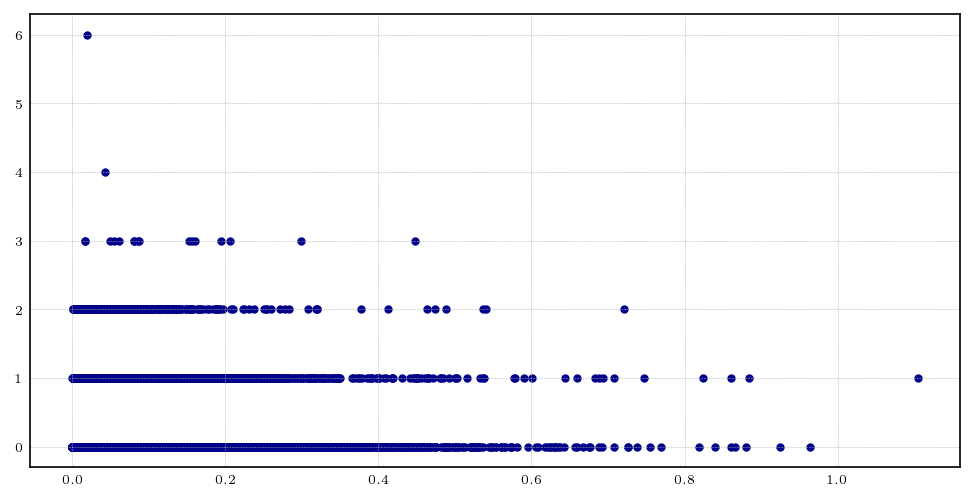

In [23]:
plt.scatter(pred, y_test.astype(np.float) )

In [26]:
def calc_obs_pred(df, feature, observed, predicted, weight):

    df_ = df.loc[:, [feature]].copy()
    if isinstance(observed, str):
        df_['observed'] = df[observed]
    else:
        df_['observed'] = observed
    if isinstance(predicted, str):
        df_['predicted'] = df[predicted]
    else:
        df_['predicted'] = predicted
    if isinstance(weight, str):
        df_['weight'] = df[weight]
    else:
        df_['weight'] = weight
        
    df_['observed'] = df_['observed'] * df_['weight']
    df_['predicted'] = df_['predicted'] * df_['weight']
    df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
          .sum()
          .assign(observed = lambda x: x['observed']/x['weight'])
          .assign(predicted = lambda x: x['predicted']/x['weight'])
         )
    return df_

In [57]:
df.shape

(678013, 11)

In [58]:
pred.shape

(678013,)

(678005,)

In [78]:
def plot_obs_pred(df, feature, observed, predicted, weight,
                  y_label=None, title=None, kind_weight=None,
                  ax=None):

    df_plot = calc_obs_pred(df, feature, observed, predicted, weight)
    ax1 = df_plot.loc[:, ['observed', 'predicted']].plot(marker = '.', linestyle = 'dashed')
    if y_label is not None:
        ax1.set_ylabel(y_label)
    ax2 = ax1.twinx()
    if kind_weight=='bar':
        df_plot['weight'].plot(kind='bar', color='g', alpha=0.1)
    else:
        ax2.fill_between(df_plot.index, 0, df_plot['weight'], color='darkgray', alpha=0.3)
    ax2.set_ylabel('Exposure')
    if title is None:
        ax2.set_title('Train: Observed vs Predicted')
    else:
        ax2.set_title(title)

In [60]:
df_plot = df.copy()
df_plot['Freq_Observed'] = df_plot['ClaimNb'] / df_plot['Exposure']
df_plot['Freq_Predicted'] = pred


<ipython-input-26-dd8974e8d82d>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


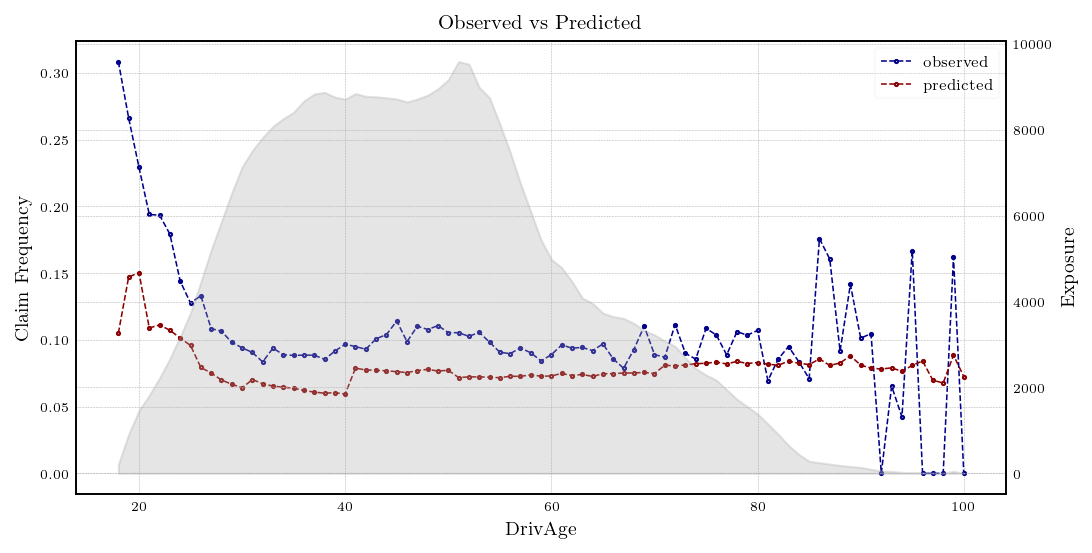

In [80]:
plot_obs_pred(df_plot, 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted')
savefig('./figures/pred1')

<ipython-input-26-dd8974e8d82d>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


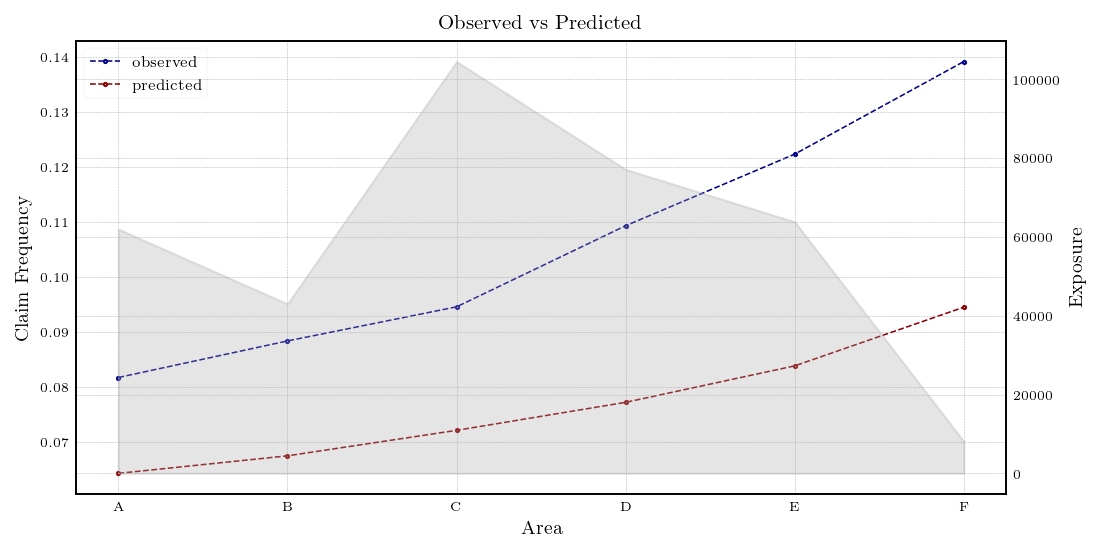

In [83]:
plot_obs_pred(df_plot, 'Area', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted')
savefig('./figures/pred4')